In [ ]:
# !pip install geopandas folium matplotlib seaborn scipy
# !pip install esda
# !pip install splot
# # for google colab, had to reinstall some pacakges.

In [109]:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [14]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
file_path1 = '/content/drive/My Drive/X999/bbl_evictions_merged_normal_times.csv'
# new name, new path

In [19]:
file_path2 = '/content/drive/My Drive/X999/svi_cleaned.csv'

In [20]:
bbl_evictions_df = pd.read_csv(file_path1)

In [21]:
svi_df = pd.read_csv(file_path2)

# **Step 1: Merge the cleaned SVI dataframe with bbl_evictions_df**

In [22]:
# only select relevant one
columns_list = ['FIPS', 'E_TOTPOP', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4', 'RPL_THEMES',
               'EP_POV150', 'EP_UNEMP', 'EP_NOHSDP', 'EP_UNINSUR','EP_AGE65', 'EP_AGE17', 'EP_DISABL', 'EP_LIMENG',
               'EP_NOVEH', 'EP_CROWD', 'EP_HBURD','EP_AFAM', 'EP_HISP', 'EP_ASIAN', 'EP_AIAN', 'EP_NHPI', 'EP_TWOMORE',
                'EP_OTHERRACE', 'EP_MINRTY']

In [23]:
# the cleaned svi df has changed all columns to lower case, so we will do it here too.
lowercase_columns = [col.lower() for col in columns_list]

In [24]:
svi_simplified = svi_df[lowercase_columns]
svi_simplified.head()

,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty
0,10001,27004,0.5688,0.1692,0.8670,0.9806,0.7414,20.3,4.3,9.1,3.1,12.7,10.0,8.6,5.3,85.5,2.7,23.1,8.2,19.3,18.6,0.0,0.0,2.9,0.8,49.8
1,10002,76518,0.9639,0.8781,0.9369,0.9254,0.9656,36.8,7.6,30.0,5.4,23.1,13.1,13.0,24.7,82.8,6.8,40.8,8.0,26.0,37.2,0.1,0.0,2.4,0.8,74.4
2,10003,53877,0.3389,0.0969,0.7977,0.9368,0.5373,14.3,4.7,4.2,2.4,15.1,7.2,6.7,2.3,80.2,3.2,21.8,5.4,10.3,16.7,0.1,0.1,3.8,0.3,36.7
3,10004,4579,0.0252,0.0769,0.8439,0.8558,0.2299,3.7,0.4,0.9,0.3,4.1,18.3,2.3,0.9,72.9,7.6,6.1,5.5,5.0,29.9,0.0,0.0,3.5,0.0,43.9
4,10005,8801,0.0631,0.0427,0.7504,0.8496,0.2437,7.4,3.4,2.5,1.2,1.8,10.5,1.1,0.3,92.3,8.4,10.9,4.8,8.6,11.2,0.0,0.0,6.5,0.0,31.0


In [25]:
svi_df.shape, svi_simplified.shape

((204, 153), (204, 26))

In [26]:
svi_simplified['ep_white'] = 100 - svi_simplified['ep_minrty']

In [27]:
bbl_evictions_df.eviction_postcode.dtype, svi_simplified.fips.dtype

(dtype('int64'), dtype('int64'))

In [28]:
bbl_evictions_df['eviction_postcode'] = bbl_evictions_df['eviction_postcode'].astype(str)
svi_simplified['fips'] = svi_simplified['fips'].astype(str)

In [29]:
merged_df = pd.merge(bbl_evictions_df,
                    svi_simplified,
                    left_on='eviction_postcode',
                    right_on='fips',
                    how='left')

# **Step 2: check nans of the merged_df**
## **Step 2.1 first glance**
After merging bbl_evictions_df and svi_simplified, we check nan, since rpl_themes is the most import column and any rows that have nan

In [36]:
merged_df.rename(columns={'eviction_postcode': 'zipcode'}, inplace=True)

In [37]:
merged_df.shape

(76715, 67)

In [38]:
merged_df.isna().sum()
# so some zipcodes simply did not exist in svi dataset

,0
primary_key,0
court_index_number,0
docket_number,0
eviction_address,0
eviction_apartment_number,0
executed_date,0
borough,0
zipcode,0
ejectment,0
eviction/legal_possession,0


In [39]:
nan_rows = merged_df[merged_df['rpl_themes'].isna()]
nan_rows.head() # the zipcodes were not matches in this case and all the svi columns are nan

,primary_key,court_index_number,docket_number,eviction_address,eviction_apartment_number,executed_date,borough,zipcode,ejectment,eviction/legal_possession,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,year,month_year,geometry,average_year_eviction_count,yearbuilt,bldgclass,numfloors,unitsres,ownername,bldgarea,building_type,building_category,is_condo,floor_category,rent_era,architectural_style,economic_period,residential_units_category,is_llc,building_size_category,size_quartile,decade,fips,e_totpop,rpl_theme1,rpl_theme2,rpl_theme3,rpl_theme4,rpl_themes,ep_pov150,ep_unemp,ep_nohsdp,ep_uninsur,ep_age65,ep_age17,ep_disabl,ep_limeng,ep_noveh,ep_crowd,ep_hburd,ep_afam,ep_hisp,ep_asian,ep_aian,ep_nhpi,ep_twomore,ep_otherrace,ep_minrty,ep_white
15,0011870/16_79081,0011870/16,79081,51-11 ALMEDA AVENUE,3E,2018-02-16,QUEENS,11691,Not an Ejectment,Possession,40.597793,-73.783072,14.0,31.0,97203.0,4436442,4160010002,Hammels-Arverne-Edgemere,2018,2018-02,POINT (-73.783072 40.597793),1.0,1963.0,D3,9.0,582.0,NYC HOUSING AUTHORITY,587170.0,post-war,elevator,False,high-rise,"1947–1969, rent-control","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),1960-1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,0070857/16_69665,0070857/16,69665,22-06 CORNAGA AVENUE,F2,2017-06-14,QUEENS,11691,Not an Ejectment,Possession,40.602185,-73.755614,14.0,31.0,100802.0,4436390,4157060001,Far Rockaway-Bayswater,2017,2017-06,POINT (-73.755614 40.602185),1.2,1948.0,C9,4.0,72.0,"2206 CORNAGA, LLC",110379.0,post-war,walk-up,False,mid-rise,"1947–1969, rent-control","1931–1950, Manhattan Modern","1946–1975, pst war economic boom",21-100 units,True,mega,Q4 (largest 25%),1940-1949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,0079738/17_85021,0079738/17,85021,1925 SEAGIRT BLVD.,9-B,2018-08-20,QUEENS,11691,Not an Ejectment,Possession,40.595128,-73.753454,14.0,31.0,99802.0,4301620,4158100025,Far Rockaway-Bayswater,2018,2018-08,POINT (-73.753454 40.595128),0.2,1966.0,D3,17.0,256.0,ISRAEL SENIOR CIT HSG,144202.0,post-war,elevator,False,high-rise,"1947–1969, rent-control","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),1960-1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
128,010747/16_201303,010747/16,201303,440 BEACH 54TH ST,08A,2017-05-10,QUEENS,11692,Not an Ejectment,Possession,40.596468,-73.784668,14.0,31.0,97203.0,4436439,4160010002,Hammels-Arverne-Edgemere,2017,2017-05,POINT (-73.784668 40.596468),2.8,1963.0,D3,9.0,582.0,NYC HOUSING AUTHORITY,587170.0,post-war,elevator,False,high-rise,"1947–1969, rent-control","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),1960-1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,010981/15_201148,010981/15,201148,444 BEACH 54TH ST,05C,2017-03-06,QUEENS,11692,Not an Ejectment,Possession,40.596569,-73.784679,14.0,31.0,97203.0,4436439,4160010002,Hammels-Arverne-Edgemere,2017,2017-03,POINT (-73.784679 40.596569),2.8,1963.0,D3,9.0,582.0,NYC HOUSING AUTHORITY,587170.0,post-war,elevator,False,high-rise,"1947–1969, rent-control","1951–1980, the International Style, Alternativ...","1946–1975, pst war economic boom",100+ units,False,mega,Q4 (largest 25%),1960-1969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
nan_rows.zipcode.unique()

array(['11691', '11692', '11694', '11693', '11381', '10360', '11442',
       '11001', '10041', '10260', '11467', '11382', '11202', '11384',
       '11040', '11443', '11240', '10424', '11266', '11137', '11272',
       '11698', '11439', '11242', '10101', '10433', '10000'], dtype=object)

## **Step2.2 remove the unmatched zipcodes**

### source: https://www.zipdatamaps.com/11443

In [47]:
these_zipcodes_with_neighborhoods = [
    '11691',  # Far rockaway (Queens)
    '11692',  # Arverne, Edgemere (Queens)
    '11694',  # Rockaway Park, Belle harbor (Queens)
    '11693',  # Broad channel (Queens)
    '11001',  # Floral park, Bellerose, etc.
    '10041',  # Financial District (Manhattan)
    '11040'   # New Hyde Park, Manhasset hills,
]
# since these are very much outskirts of nyc neighborhoods, and they represent a very small portion of the
# whole dataset, we will remove these rows with nans

In [48]:
zipcodes_not_in_use = [
    '11381','10360','11442','10260','11467','11382','11202','11384','11443','11240','10424','11266','11137','11272','11698',
    '11439','11242','10101','10433','10000']

In [56]:
merged_df[merged_df['zipcode'].isin(zipcodes_not_in_use + these_zipcodes_with_neighborhoods)].groupby('borough').size()

,0
borough,
BRONX,2
BROOKLYN,5
MANHATTAN,5
QUEENS,1692
STATEN ISLAND,1


In [49]:
missing_svi = merged_df['rpl_themes'].isna().sum()
print(missing_svi/len(merged_df)*100,"% missing rows")

2.222511894675096 % missing rows


In [51]:
missing_svi, merged_df.shape

(np.int64(1705), (76715, 67))

In [53]:
missing_postcodes = merged_df[merged_df['rpl_themes'].isna()]['zipcode'].unique()
missing_postcodes

array(['11691', '11692', '11694', '11693', '11381', '10360', '11442',
       '11001', '10041', '10260', '11467', '11382', '11202', '11384',
       '11040', '11443', '11240', '10424', '11266', '11137', '11272',
       '11698', '11439', '11242', '10101', '10433', '10000'], dtype=object)

### **We will save them to a seperate csv, but will remove them from the merged_df (these zipcodes are less likely to be used in the end)**

In [58]:
merged_df['invalid_zip'] = merged_df['zipcode'].isin([
    '11381', '10360', '11442', '10260', '11467', '11382', '11202', '11384','11443', '11240', '10424', '11266',
    '11137', '11272', '11698', '11439','11242', '10101', '10433', '10000'
])

In [60]:
invalid_zip_df = merged_df[merged_df['invalid_zip']]
invalid_zip_df.to_csv('/content/drive/My Drive/X999/invalid_zip_backup.csv', index=False)

In [61]:
merged_df= merged_df[~merged_df['invalid_zip']].copy()

In [62]:
missing_postcodes = merged_df[merged_df['rpl_themes'].isna()]['zipcode'].unique()

In [65]:
merged_df_clean = merged_df[~merged_df['zipcode'].isin(missing_postcodes)]
merged_df.shape, merged_df_clean.shape, len(merged_df) - len(merged_df_clean)

((76690, 68), (75010, 68), 1680)

In [67]:
merged_df_clean.isna().sum() # now, all the nans are from the building feature columns

,0
primary_key,0
court_index_number,0
docket_number,0
eviction_address,0
eviction_apartment_number,0
executed_date,0
borough,0
zipcode,0
ejectment,0
eviction/legal_possession,0


In [ ]:
# merged_df_clean.columns

# **Step 3 Correlation tests on the main SVI metrics and average_year_eviction_count**

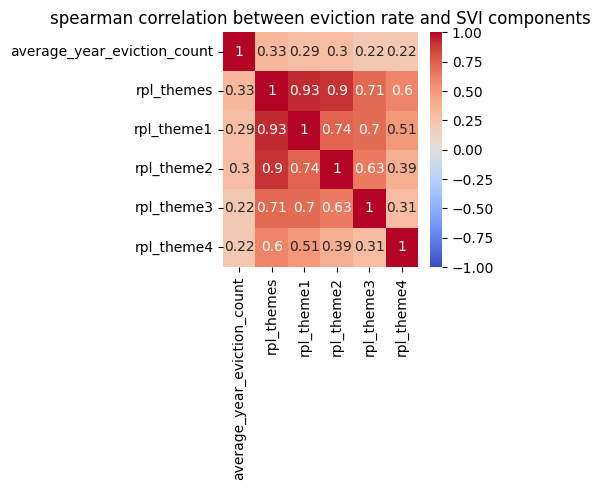

In [71]:
key_vars = ['average_year_eviction_count', 'rpl_themes', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4']
correlation_heatmap = merged_df_clean[key_vars].corr(method='spearman')

plt.figure(figsize=(5, 5))
sns.heatmap(correlation_heatmap, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('spearman correlation between eviction rate and SVI components')
plt.tight_layout()

In [78]:
variables = [], correlations = [], p_values = [], significance = []

In [79]:
for var, results in correlation_results.items():
    variables.append(var)
    correlations.append(results['correlation'])
    p_values.append(results['p_value'])
    significance.append("significant" if results['p_value'] < 0.05 else "not significant")

In [82]:
correlation_df = pd.DataFrame({'variables': variables, 'correlations': correlations, 'p_value': p_values,
                               'significance': significance})

In [83]:
correlation_df['correlations'] = correlation_df['correlations'].map('{:.3f}'.format)
correlation_df['p_value'] = correlation_df['p_value'].map('{:.4f}'.format)
correlation_df

,variables,correlations,p_value,significance
0,rpl_themes,0.329,0.0000,significant
1,rpl_theme1,0.290,0.0000,significant
2,rpl_theme2,0.302,0.0000,significant
3,rpl_theme3,0.224,0.0000,significant
4,rpl_theme4,0.222,0.0000,significant


**The relatively weak/moderate correlations between eviction rates and SVI components suggest that evictions in NYC are not simply driven by social vulnerability as measured by the SVI. The household composition/disability theme having the strongest correlation (but still weak) might indicate that household structure and disability status may be slightly more relevant to eviction risk than other vulnerability factors.**

In [85]:
merged_df_clean.columns

Index(['primary_key', 'court_index_number', 'docket_number',
       'eviction_address', 'eviction_apartment_number', 'executed_date',
       'borough', 'zipcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'year', 'month_year', 'geometry',
       'average_year_eviction_count', 'yearbuilt', 'bldgclass', 'numfloors',
       'unitsres', 'ownername', 'bldgarea', 'building_type',
       'building_category', 'is_condo', 'floor_category', 'rent_era',
       'architectural_style', 'economic_period', 'residential_units_category',
       'is_llc', 'building_size_category', 'size_quartile', 'decade', 'fips',
       'e_totpop', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4',
       'rpl_themes', 'ep_pov150', 'ep_unemp', 'ep_nohsdp', 'ep_uninsur',
       'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh',
       'ep_crowd', 'ep_hburd', 'ep_afam', 'ep_hisp', 'ep_asian',

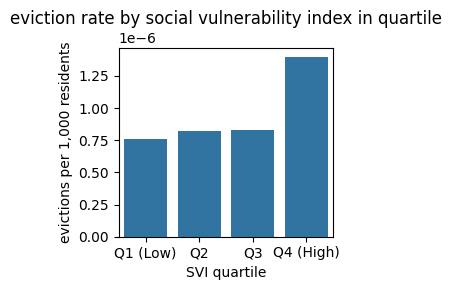

In [88]:
merged_df_clean['svi_quartile'] = pd.qcut(merged_df_clean['rpl_themes'], 4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])
quartile_analysis = merged_df_clean.groupby('svi_quartile').agg({
    'average_year_eviction_count': 'mean',
    'e_totpop': 'sum'
}).reset_index()
quartile_analysis['total_eviction_rate'] = quartile_analysis['average_year_eviction_count'] / quartile_analysis['e_totpop'] * 1000
plt.figure(figsize=(3, 3))
sns.barplot(x='svi_quartile', y='total_eviction_rate', data=quartile_analysis)
plt.title('eviction rate by social vulnerability index in quartile')
plt.ylabel('evictions per 1,000 residents')
plt.xlabel('SVI quartile')
plt.tight_layout()

Though with weak/moderate correlation, we do see more people with higher svi score experienced more evictions than others.

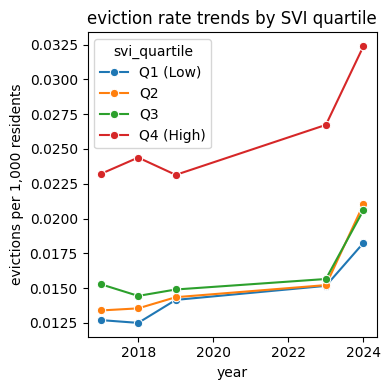

In [90]:
time_analysis = merged_df_clean.groupby(['year', 'svi_quartile']).agg({
    'average_year_eviction_count': 'sum',
    'e_totpop': 'sum'
}).reset_index()
time_analysis['yearly_eviction_rate'] = time_analysis['average_year_eviction_count'] / time_analysis['e_totpop'] * 1000

plt.figure(figsize=(4, 4))
sns.lineplot(x='year', y='yearly_eviction_rate', hue='svi_quartile', data=time_analysis, marker='o')
plt.title('eviction rate trends by SVI quartile')
plt.ylabel('evictions per 1,000 residents')
plt.xlabel('year')
plt.tight_layout()

**Based on the bar chart and line plot, SVI scores seem to be a solid indicator for evictions during normal times.**

# **Step 4: Multilinear regression tests on svi and evictions**

In [91]:
merged_df_clean.columns

Index(['primary_key', 'court_index_number', 'docket_number',
       'eviction_address', 'eviction_apartment_number', 'executed_date',
       'borough', 'zipcode', 'ejectment', 'eviction/legal_possession',
       'latitude', 'longitude', 'community_board', 'council_district',
       'census_tract', 'bin', 'bbl', 'nta', 'year', 'month_year', 'geometry',
       'average_year_eviction_count', 'yearbuilt', 'bldgclass', 'numfloors',
       'unitsres', 'ownername', 'bldgarea', 'building_type',
       'building_category', 'is_condo', 'floor_category', 'rent_era',
       'architectural_style', 'economic_period', 'residential_units_category',
       'is_llc', 'building_size_category', 'size_quartile', 'decade', 'fips',
       'e_totpop', 'rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4',
       'rpl_themes', 'ep_pov150', 'ep_unemp', 'ep_nohsdp', 'ep_uninsur',
       'ep_age65', 'ep_age17', 'ep_disabl', 'ep_limeng', 'ep_noveh',
       'ep_crowd', 'ep_hburd', 'ep_afam', 'ep_hisp', 'ep_asian',

In [94]:
X = merged_df_clean[['rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4']]
X = sm.add_constant(X)
y = merged_df_clean['average_year_eviction_count']

model = sm.OLS(y, X).fit()

In [96]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     average_year_eviction_count   R-squared:                       0.006
Model:                                     OLS   Adj. R-squared:                  0.006
Method:                          Least Squares   F-statistic:                     108.4
Date:                         Wed, 26 Mar 2025   Prob (F-statistic):           3.10e-92
Time:                                 04:18:44   Log-Likelihood:            -1.7693e+05
No. Observations:                        75010   AIC:                         3.539e+05
Df Residuals:                            75005   BIC:                         3.539e+05
Df Model:                                    4                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**R-squared of 0.006 means only 0.6% of the variation in eviction counts is explained by these SVI themes, this is a bit unexpected, as the bar chart indicated otherwise. However, it could make sense. The discrepancy between bar chart showing higher evictions in areas with higher SVI scores and the regression results (particularly the negative coefficient for rpl_theme1) is likely due to the multicollinearity problem.**



In [100]:
# check multicollinearity
vif_data = pd.DataFrame()
vif_data["variables"] = X.columns
vif_data["vif"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,variables,vif
0,const,1.598108
1,rpl_theme1,1794.514463
2,rpl_theme2,833.743928
3,rpl_theme3,2.000009
4,rpl_theme4,1134.393139


### **Unsurpisingly, the vif is very high (anything above 10 is problematic as they correlate too much). This means these variables are highly correlated with each other, making coefficient estimates unstable, increasing standard errors, and making it difficult to interpret which variables truly affect evictions. As a rule of thumb, we will use PCA (principal component analysis)**

In [118]:
svi_columns = ['rpl_theme1', 'rpl_theme2', 'rpl_theme3', 'rpl_theme4']
cleaned_df = merged_df_clean.dropna(subset=svi_columns + ['average_year_eviction_count'])
y = cleaned_df['average_year_eviction_count']

In [119]:
# standardize
svi_features = cleaned_df[svi_columns]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(svi_features)

In [120]:
# pca
pca = PCA()
pca_features = pca.fit_transform(scaled_features)

In [121]:
f"explained variance ratio:", pca.explained_variance_ratio_

('explained variance ratio:',
 array([8.94948606e-01, 1.04717124e-01, 2.42768649e-04, 9.15014277e-05]))

In [132]:
X_pca = pd.DataFrame(pca_features[:, 0:2], columns=['pc1', 'pc2'], index=cleaned_df.index )
X_pca = sm.add_constant(X_pca)

In [133]:
pca_model = sm.OLS(y, X_pca).fit()
print(pca_model.summary())

                                 OLS Regression Results                                
Dep. Variable:     average_year_eviction_count   R-squared:                       0.000
Model:                                     OLS   Adj. R-squared:                 -0.000
Method:                          Least Squares   F-statistic:                    0.8148
Date:                         Wed, 26 Mar 2025   Prob (F-statistic):              0.443
Time:                                 04:56:39   Log-Likelihood:            -1.7714e+05
No. Observations:                        75010   AIC:                         3.543e+05
Df Residuals:                            75007   BIC:                         3.543e+05
Df Model:                                    2                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Interestingly, the R-square score is 0, but it does show strong influences within these inputs, as expected. This can be explained by these reasons: 1) other variables might be driving both SVI scores and eviction rates, as they cannot be linearly explained by SVI.
2) spatial effects: geographical clustering is a way more important factor (as confirmed from another file) but not captured in this model.

In [134]:
cleaned_df[['rpl_themes', 'average_year_eviction_count']].corr()
# a quick check of the correlation

,rpl_themes,average_year_eviction_count
rpl_themes,1.000000,0.003552
average_year_eviction_count,0.003552,1.000000


In [105]:
merged_df_clean['svi_group'] = pd.qcut(merged_df_clean['rpl_themes'], 4, labels=['low', 'medium-low', 'medium-high', 'high'])
svi_group_stats = merged_df_clean.groupby('svi_group')['average_year_eviction_count'].agg(['mean', 'median', 'count'])
svi_group_stats
# analyze in SVI quartiles to check for non-linear relationships

,mean,median,count
svi_group,,,
low,0.762033,0.4,18848
medium-low,1.099770,0.4,18663
medium-high,1.133254,0.6,19324
high,1.856066,1.0,18175


**Overally, svi is not the deterministic factor of the evictions, as evictions are a very complex Societal issue that involves numerous factors, besides racial composites, family income, or family composites (people's age, unemployment rates, disability, etc. ) that could be captured by SVI. Other factors not captured in the SVI (such as local housing policies, landlord practices, or rental market conditions) likely play important roles.**

Quick notes: this is not a linear relationship. will need to come back. 